|                                        |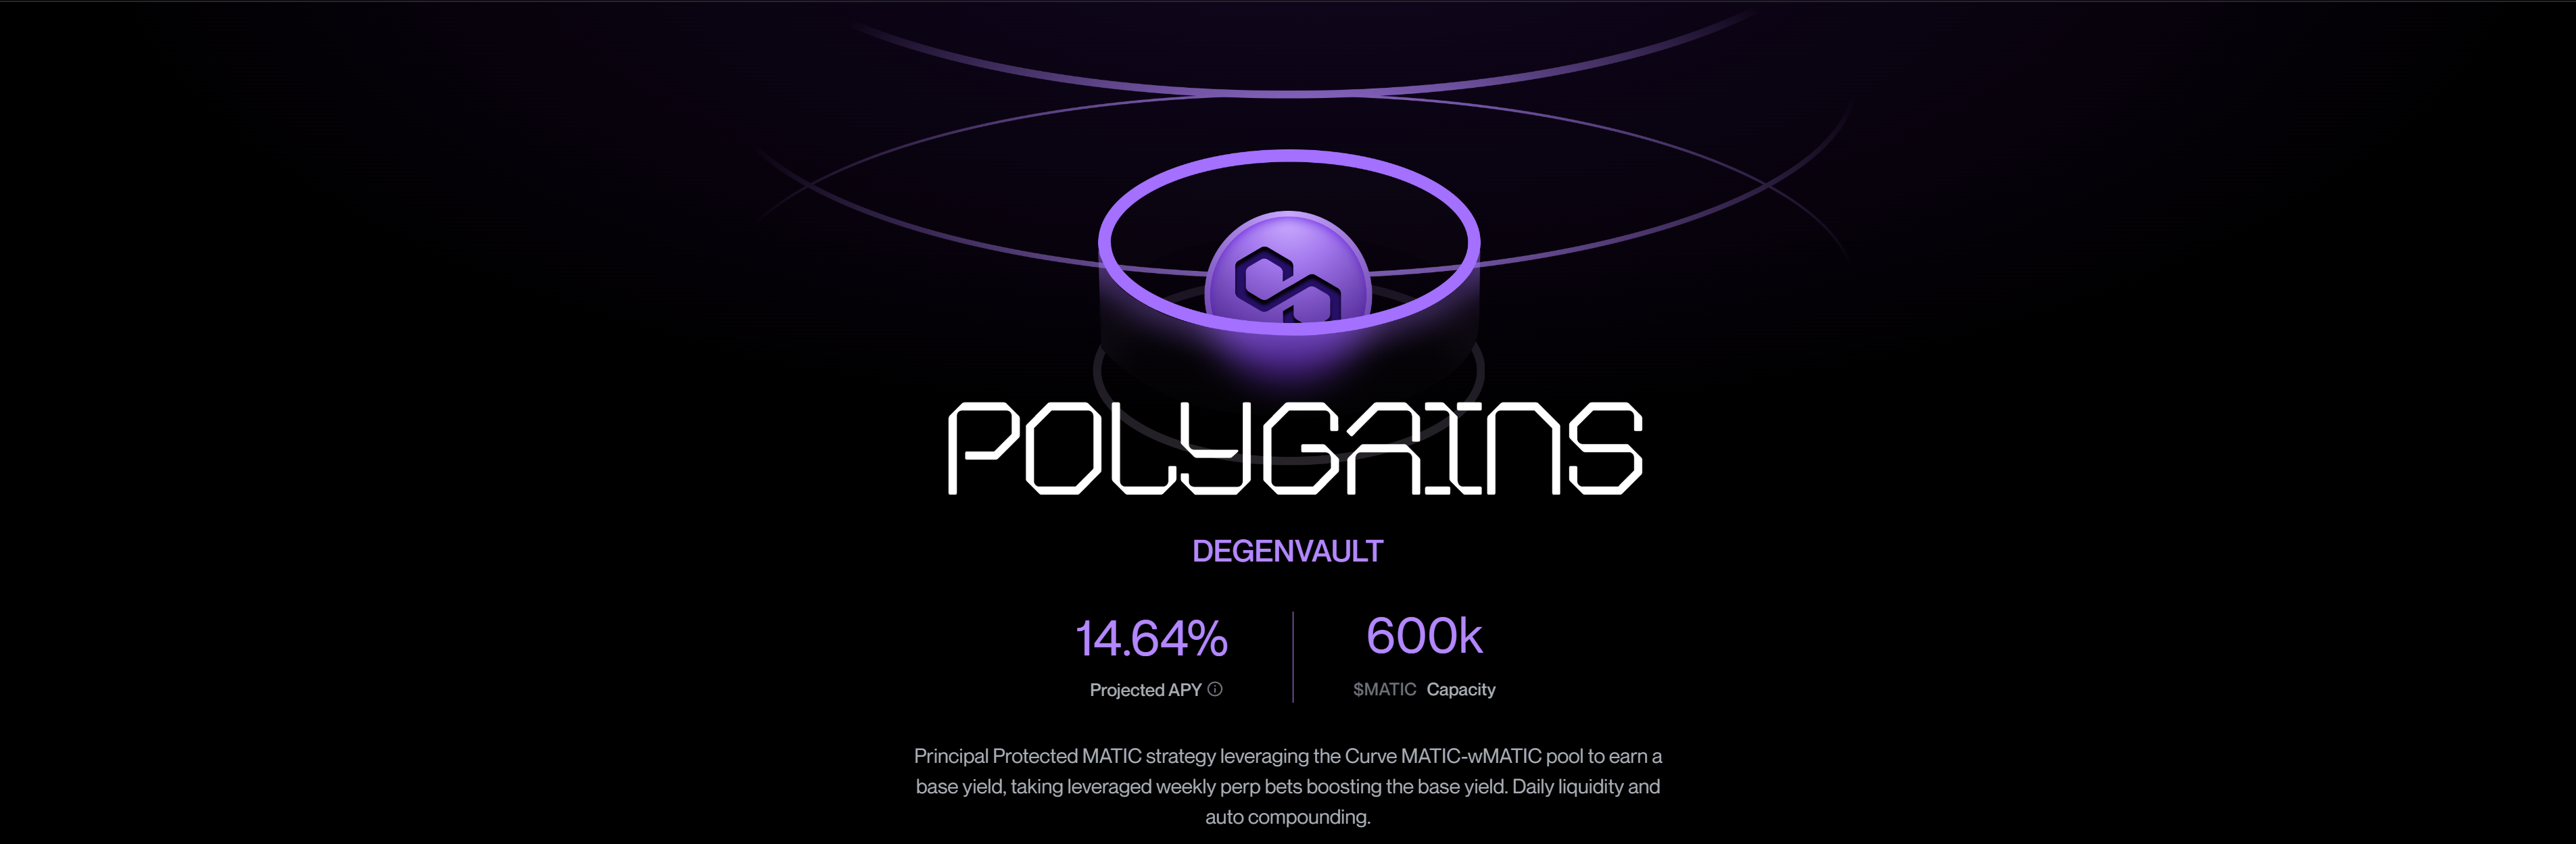|                                  |
|----------------------------------------|                                                                 |----------------------------------|


# Polygains DegenVault Backtest 

##  Strategy  Idea:

PolyGains Degenvault follows an already signature Brahma structure, with a degen flare to it. The goal is to profit from  the volatile nature of crypto assets by taking leveraged trading positions while simultaneously protecting the initial capital with Polygon-native staking.

The procedure looks as follows:

1. The degenvault receives MATIC deposits.
2. The funds are safely parked and multiplied in the stMATIC / MATIC Curve V2 Pool.
3. The base yield is harvested weekly and sent to Perpetual Protocol.
4. This yield is used to take a leveraged bet based on an algorithmic momentum strategy trained to provide high-confidence signals.
5. The position's risk is monitored with a dynamic stop-loss algorithm.
6. All trading profits are compounded back into the strategy.


|                                	| Parameter value 	|
|--------------------------------	|-----------------	|
| __Trade frequency__            	| 7 days          	|
| __Trade leverage__             	| 1              	|
| __Absolute signal confidence__ 	| 4               	|
| __Base Pool__                 	| https://curve.fi/#/ethereum/pools/steth/swap |


|                                	|![image.png](https://blog.brahma.fi/content/images/size/w1600/2022/09/image.png)|                                	|
|-----------------------------------|--------------------------------------------------------------------------------|---------------------------------|




## Implementation

### Imports

In [1]:
# General modules import
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime,timedelta,timezone

sns.set(palette='deep')
sns.set(style="darkgrid", context="talk")
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
%matplotlib inline

%matplotlib inline

In [2]:
# Brahma modules imports
import sys
sys.path.append("../../")
from modules.defibulizer.offchain_defibulizer import DeFibulizer
from modules.backtesting.perp_backtest import PerpBacktest
from modules.util.data_helpers import group_historical_data
from modules.util.backtest_helpers import ts_signal_prep, get_str_date
from modules.constants.polygains_const import PARAMS as pr

### Downloading the hourly data

For this backtest we gather 1year of historical data consisting of:
 * Price history data for MATIC

In [3]:
dt = DeFibulizer()

start_date = datetime(2021,3,26,8,tzinfo=timezone.utc)
end_date = datetime(2022,5,20,8,tzinfo=timezone.utc)

# Downloading the raw data
raw_data = dt.get_data(['MATICUSDT-PERP'], start_date, end_date, frequency='h')
raw_data.index = pd.to_datetime(raw_data.index)

# Preprocessing only the needed columns for the backtest
hourly_prices = raw_data['MATICUSDT-PERP'][['open','high','low','close']]

# Getting the str date formats for file navigation
start_date_str = get_str_date(start_date)
end_date_str = get_str_date(end_date)

### Establishing the Hyperparameters

First we are going to set up all of the backtest hyperparameters:

In [4]:
#General Parameters

base_yield = pr['base_yield'] # Deposit yield
trade_freq = pr['trade_freq'] # Interest harvest and trade frequency (days)
is_usd = pr['is_usd'] # Whether the asset conversion is occuring in the strategy

In [5]:
# Signal Parameters

short_window = pr['short_window'] 
long_window = pr['long_window']
confidence = pr['confidence']

In [6]:
# Bet Parameters

stop_loss = pr['stop_loss']
take_profit = pr['take_profit']
leverage = pr['leverage'] 

Next we will construct a TS position signal based on the given hyperparameters

In [7]:
tr_scan_labels_short = pd.read_csv(f'ts_data/ts_{short_window}_{start_date_str}_{end_date_str}_open.csv').set_index('time')
tr_scan_labels_long = pd.read_csv(f'ts_data/ts_{long_window}_{start_date_str}_{end_date_str}_open.csv').set_index('time')

In [8]:
positions = ts_signal_prep(tr_scan_labels_short, tr_scan_labels_long, confidence)

### Running The Backtest

In [9]:
backtest = PerpBacktest(price_data=hourly_prices,position_data=positions, rate=base_yield,
                        take_profit=take_profit, stop_loss=stop_loss,
                        trade_freq=trade_freq, leverage=leverage,
                        is_usd=is_usd)

Backtest results record every valuable parameter for further reseach during each epoch.

In [10]:
backtest.backtest_results.tail(1)

,position_open_time,position_close_time,open,close,high,low,position,price_change,stop_loss_price,take_profit_price,exit_type,trade_duration,position_return,vault_balance_start,vault_balance_end,invested_yield_base,invested_yield_usd,trade_profit_base,benchmark,transaction_fee
time,,,,,,,,,,,,,,,,,,,,
2022-05-20 08:00:00+00:00,2022-05-13 08:00:00+00:00,2022-05-20 08:00:00+00:00,0.6817,0.6529,0.7528,0.6085,0,-0.042247,0.0,0.0,0,0 days,0.0,1.264016,1.267586,0.00357,0.002434,0.0,1.184691,0.0


### Backtest Metrics

Strategy metrics:

In [11]:
backtest.strategy_metrics

,0
Strategy Yield,26.758629
Strategy APY,23.583876
Benchmark APY,16.277891
Trading Boost,1.448829
Sharpe Ratio,8.106295
Max Drawdown,0.000000


Signal metrics:

In [12]:
backtest.signal_metrics

,0
Epochs,60.000000
% Trades,0.716667
% Longs,0.441860
% Shorts,0.558140
Trade Hit Rate %,0.372093
Signal Hit Rate %,0.627907


### __Backtest Performance Visualisation__

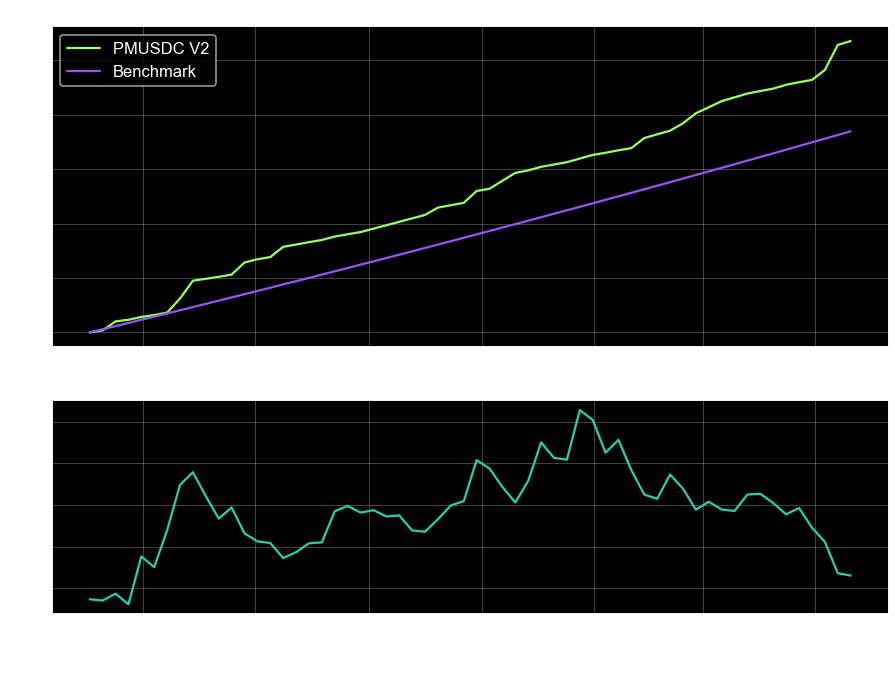

In [13]:
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]}, sharex=True);

backtest.backtest_results.vault_balance_end.plot(figsize = (15,12), ax=axs[0], title='Strategy Performance', legend = True, color='#97ff5a');
backtest.backtest_results.benchmark.plot(figsize = (15,12), ax=axs[0], legend = True, color='#9654F4');
axs[0].legend(['PMUSDC V2', 'Benchmark']);
backtest.backtest_results.close.plot(ax=axs[1], title='$MATIC Price', legend=False, color='#27CEAF');